# Baseline Modeling

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import gensim
import fasttext
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import gensim
from sklearn.neural_network import MLPClassifier

import sys
from pathlib import Path
import os

In [2]:
path = Path(os.path.dirname(os.getcwd()))
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/saideepbunny/Projects/HuffPost-News-classification


In [3]:
from utils.utils import preprocess_text, evaluate_model, get_embedding_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saideepbunny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saideepbunny/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/saideepbunny/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Reading data

In [4]:
df = pd.read_json(f'{path}/data/train_data.json', orient='records')
df

,headline,category,short_description,authors,date,headline_length,short_description_length
0,Stephen Colbert Hits Trump With The Perfect 'S...,ENTERTAINMENT,"""Late Show"" host has a correction for the pres...",Ed Mazza,2018-01-12,63,52
1,Dear Colleagues: We SUCK!,WELLNESS,"I'm not saying we are wrong. In fact, we may a...","David Katz, M.D., ContributorFounder, True Hea...",2015-03-10,25,220
2,Emily Fletcher Shares Guided Meditation Techni...,WELLNESS,Meditation doesn't have to be complicated. In ...,None,2013-11-28,57,120
3,HuffPost Rise: What You Need To Know On Februa...,POLITICS,Welcome to the HuffPost Rise Morning Newsbrief...,None,2016-02-15,51,103
4,3 Ways To Fight Overwhelm And Add Joy To Your ...,WELLNESS,Working moms are juggling more than ever befor...,"Paula Jenkins, ContributorLife Coach and Host ...",2016-07-09,50,123
...,...,...,...,...,...,...,...
61970,Owning An Assault Weapon Is No Longer A Fundam...,POLITICS,An appeals court wiped out an earlier ruling t...,Cristian Farias,2016-03-06,68,94
61971,Blackfish: Rooting for Killer Whales and Kille...,ENTERTAINMENT,A debate ensued that resonates for yet another...,"Regina Weinreich, Contributor\nAuthor, 'Keroua...",2013-06-22,69,121
61972,Trevor Noah Mockingly Praises Trump's 'Right R...,ENTERTAINMENT,"""Now I know your first instinct is to be disgu...",Lee Moran,2017-11-28,73,125
61973,Elite 'Bundlers' Raise More Than $113 Million ...,POLITICS,"Big backers include Ben Affleck, George Lucas,...","Michael Beckel, Center for Public Integrity",2016-09-23,65,81


## Preprocessing data

In [5]:
df['content'] = df['headline'] + df['short_description']
df['content_preprocessed'] = df['content'].apply(lambda x: preprocess_text(x))

In [6]:
target_map = {'ENTERTAINMENT':0, 'WELLNESS':1, 'POLITICS':2}
df['category'] = df['category'].map(target_map).copy()

## Buidling baseline XGBoost model

In [7]:
def create_embeddings_train_model(estimator, data_df, embedding_model, embedding_model_name):

    embedding_dim = int(embedding_model_name.split('_')[-1].split('.')[0])

    #generating embeddings
    data_df, embed_cols = get_embedding_df(data_df, embedding_dim, embedding_model)

    #Defining train and test data
    X = data_df[embed_cols]
    y = data_df['category']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    #Training the model
    estimator.fit(X_train, y_train)

    #evaluating metrics
    metrics = evaluate_model(estimator, X_train, y_train, X_test, y_test, display_metrics=True)
    for k in metrics:
        k['Embedding_dim'] = embedding_dim

    
    return metrics


def run_embedding_model_training(data_df, estimator, embedding_models, embedding_type):
    results = []
    
    for model_name in embedding_models:
        #loading model
        if('fasttext' in embedding_models[0]):
            model = fasttext.load_model(f"{path}/embeddings/{model_name}")
        else:
            model = gensim.models.Word2Vec.load(f"{path}/embeddings/{model_name}")
    
        #training the model
        metrics = create_embeddings_train_model(estimator, data_df, model, model_name)
        results.extend(metrics)
        
        print('\n'+ '*'*90 + '\n')
    
    res_df = pd.DataFrame(results)
    res_df['Embedding_model'] = embedding_type.capitalize()
    return res_df

### Fasttext

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     13965
           1       0.99      0.99      0.99     14853
           2       0.98      0.99      0.98     20762

    accuracy                           0.98     49580
   macro avg       0.98      0.98      0.98     49580
weighted avg       0.98      0.98      0.98     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      3491
           1       0.92      0.92      0.92      3713
           2       0.89      0.91      0.90      5191

    accuracy                           0.89     12395
   macro avg       0.89      0.89      0.89     12395
weighted avg       0.89      0.89      0.89     12395



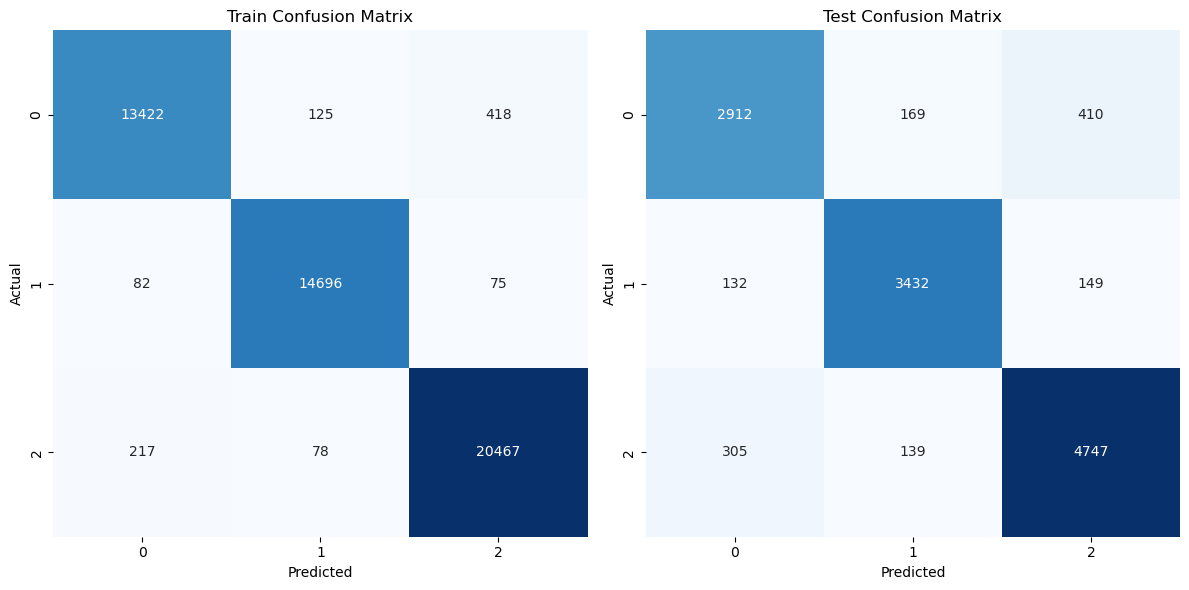


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     13965
           1       0.99      1.00      0.99     14853
           2       0.99      0.99      0.99     20762

    accuracy                           0.99     49580
   macro avg       0.99      0.99      0.99     49580
weighted avg       0.99      0.99      0.99     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.88      0.83      0.85      3491
           1       0.91      0.92      0.92      3713
           2       0.89      0.92      0.90      5191

    accuracy                           0.89     12395
   macro avg       0.89      0.89      0.89     12395
weighted avg       0.89      0.89      0.89     12395



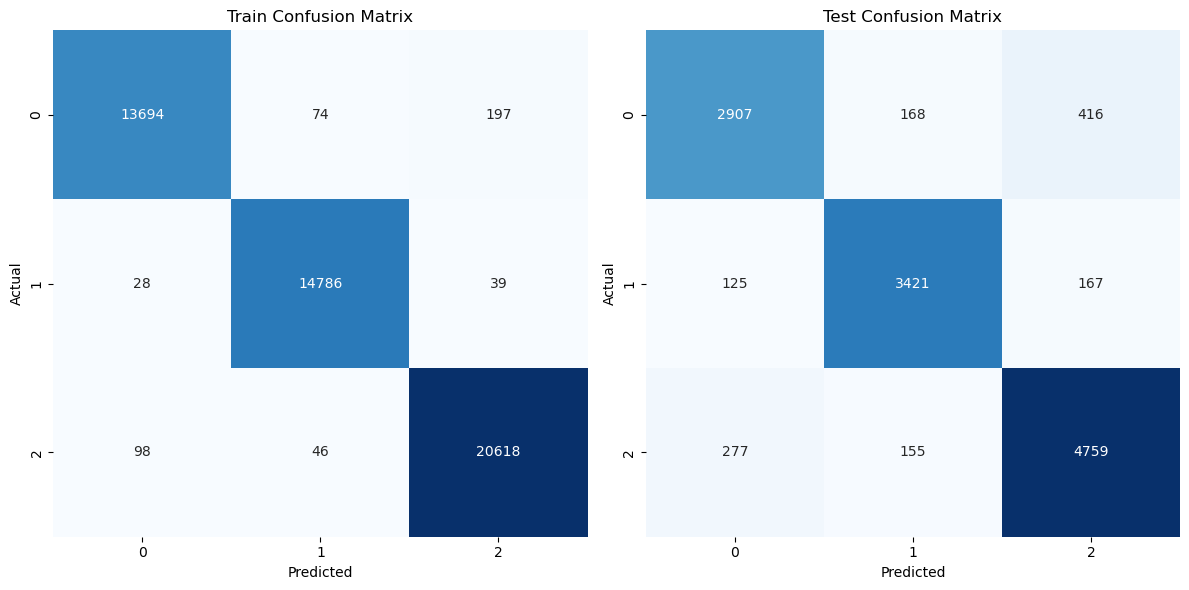


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     13965
           1       0.99      1.00      1.00     14853
           2       0.99      1.00      0.99     20762

    accuracy                           0.99     49580
   macro avg       0.99      0.99      0.99     49580
weighted avg       0.99      0.99      0.99     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      3491
           1       0.92      0.92      0.92      3713
           2       0.89      0.92      0.90      5191

    accuracy                           0.89     12395
   macro avg       0.89      0.89      0.89     12395
weighted avg       0.89      0.89      0.89     12395



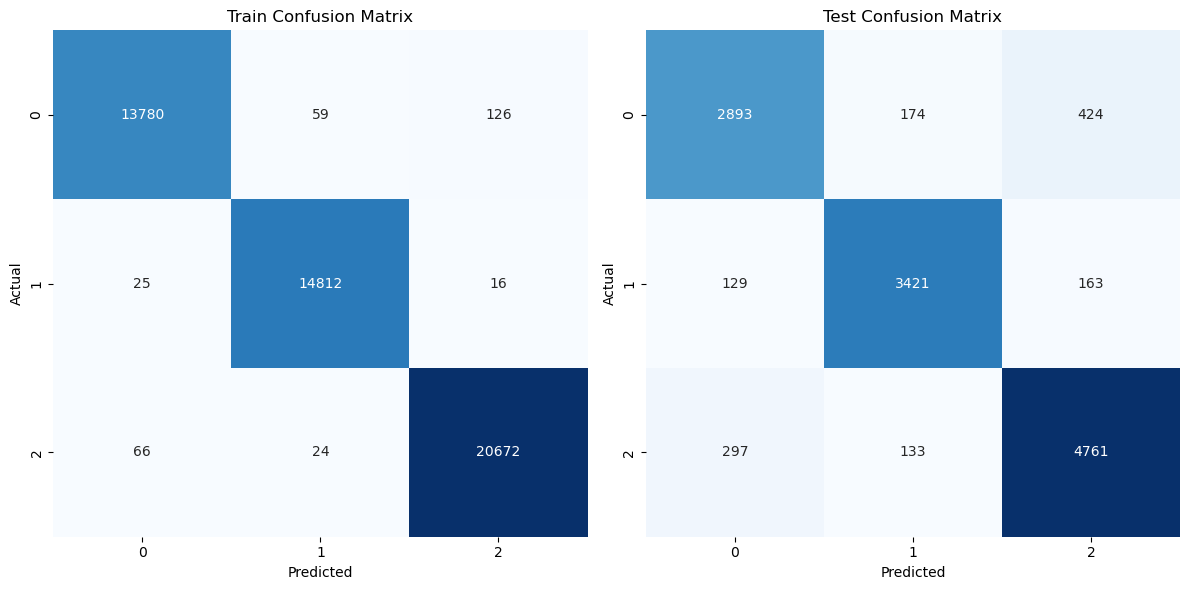


******************************************************************************************



,Estimator,Dataset,Accuracy,Precision,Recall,F1 Score,Embedding_dim,Embedding_model
0,XGBClassifier,Train,0.979931,0.980354,0.978779,0.979534,100,Fasttext
1,XGBClassifier,Test,0.894796,0.893936,0.890977,0.892294,100,Fasttext
2,XGBClassifier,Train,0.990278,0.990505,0.989716,0.990099,200,Fasttext
3,XGBClassifier,Test,0.894474,0.894369,0.890283,0.892054,200,Fasttext
4,XGBClassifier,Train,0.993626,0.993682,0.993219,0.993445,300,Fasttext
5,XGBClassifier,Test,0.893505,0.893179,0.889075,0.890878,300,Fasttext


In [8]:
fasttext_res_df = run_embedding_model_training(data_df=df,
                                               estimator=XGBClassifier(random_state=42),
                                               embedding_models=['fasttext_model_100.bin', 'fasttext_model_200.bin', 'fasttext_model_300.bin'],
                                               embedding_type='fasttext')

fasttext_res_df

### Word2Vec

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     13965
           1       0.98      0.99      0.99     14853
           2       0.98      0.99      0.98     20762

    accuracy                           0.98     49580
   macro avg       0.98      0.98      0.98     49580
weighted avg       0.98      0.98      0.98     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      3491
           1       0.91      0.92      0.92      3713
           2       0.89      0.90      0.90      5191

    accuracy                           0.89     12395
   macro avg       0.89      0.89      0.89     12395
weighted avg       0.89      0.89      0.89     12395



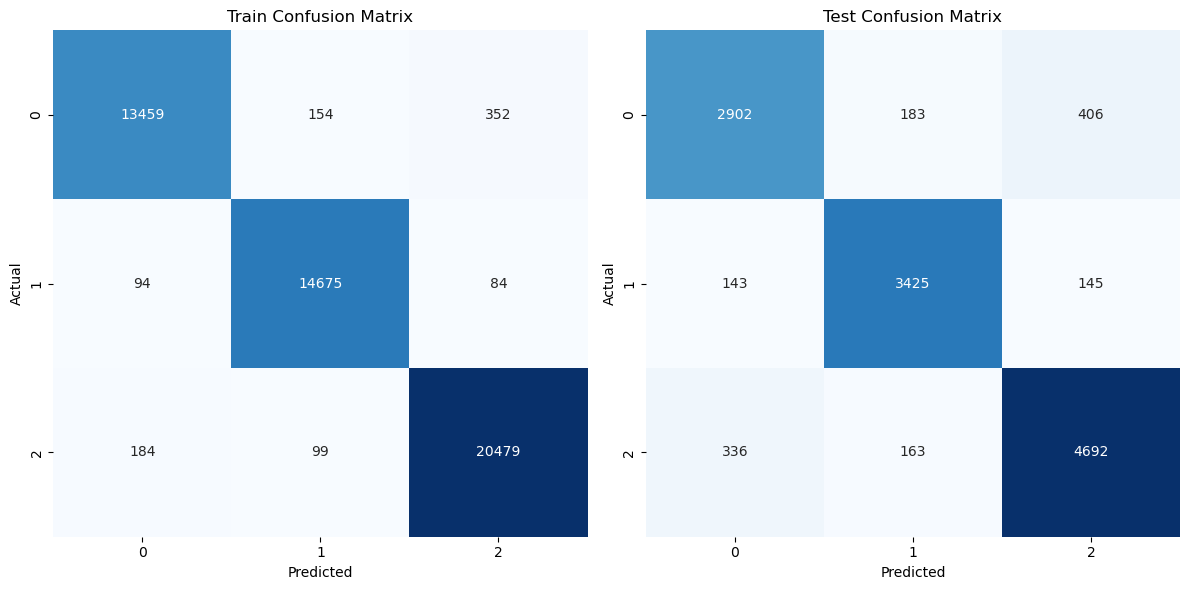


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     13965
           1       0.99      0.99      0.99     14853
           2       0.99      0.99      0.99     20762

    accuracy                           0.99     49580
   macro avg       0.99      0.99      0.99     49580
weighted avg       0.99      0.99      0.99     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      3491
           1       0.91      0.92      0.91      3713
           2       0.89      0.91      0.90      5191

    accuracy                           0.89     12395
   macro avg       0.89      0.88      0.88     12395
weighted avg       0.89      0.89      0.89     12395



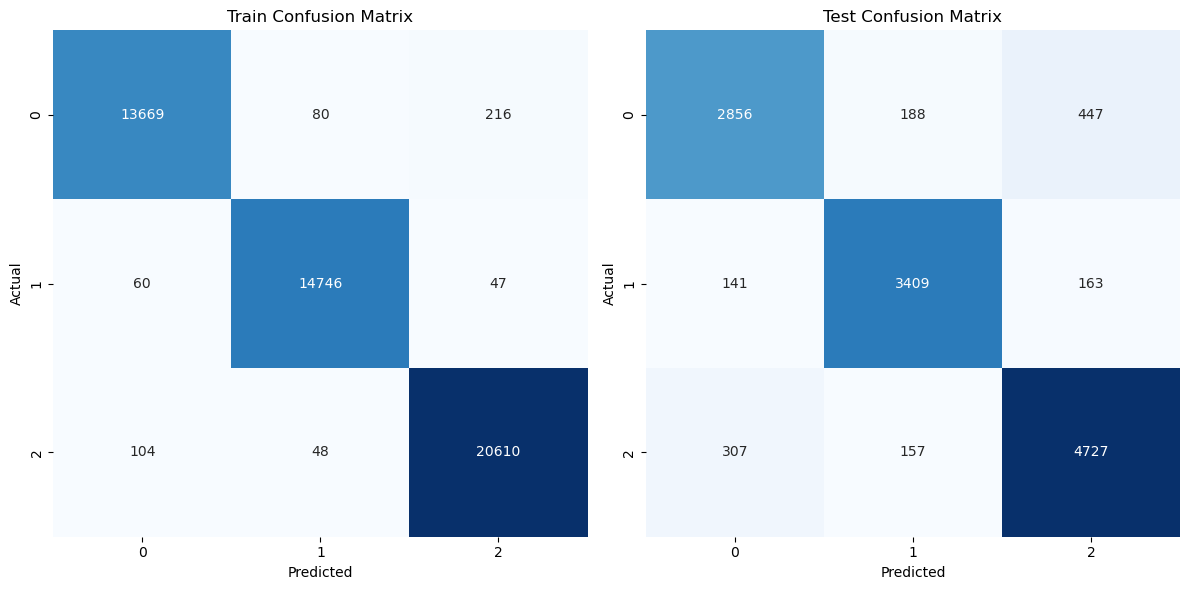


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     13965
           1       0.99      1.00      1.00     14853
           2       0.99      0.99      0.99     20762

    accuracy                           0.99     49580
   macro avg       0.99      0.99      0.99     49580
weighted avg       0.99      0.99      0.99     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.81      0.84      3491
           1       0.90      0.92      0.91      3713
           2       0.88      0.91      0.89      5191

    accuracy                           0.88     12395
   macro avg       0.88      0.88      0.88     12395
weighted avg       0.88      0.88      0.88     12395



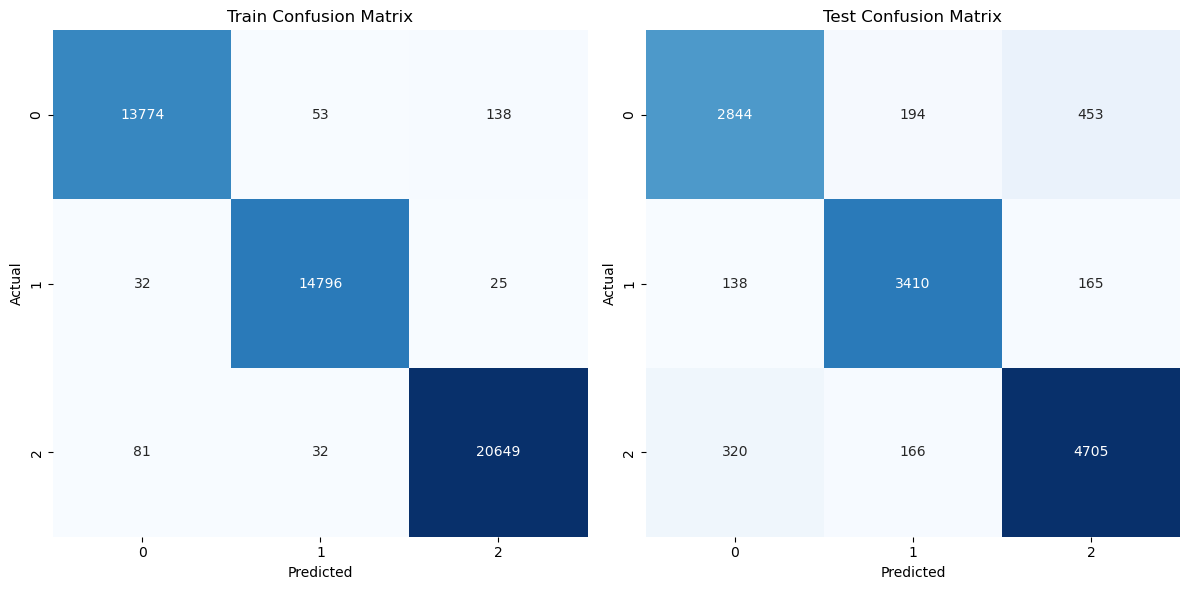


******************************************************************************************



,Estimator,Dataset,Accuracy,Precision,Recall,F1 Score,Embedding_dim,Embedding_model
0,XGBClassifier,Train,0.980496,0.980656,0.979384,0.979992,100,Word2vec
1,XGBClassifier,Test,0.888987,0.887160,0.885862,0.886413,100,Word2vec
2,XGBClassifier,Train,0.988806,0.988980,0.988093,0.988526,200,Word2vec
3,XGBClassifier,Test,0.886809,0.886069,0.882281,0.883896,200,Word2vec
4,XGBClassifier,Train,0.992719,0.992773,0.992348,0.992557,300,Word2vec
5,XGBClassifier,Test,0.884147,0.883235,0.879813,0.881243,300,Word2vec


In [9]:
word2vec_res_df = run_embedding_model_training(data_df=df,
                                               estimator=XGBClassifier(random_state=42),
                                               embedding_models=['word2vec_model_100.model', 'word2vec_model_200.model', 'word2vec_model_300.model'],
                                               embedding_type='word2vec')

word2vec_res_df

### Skipgram

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.99      0.96      0.97     13965
           1       0.98      0.99      0.99     14853
           2       0.98      0.99      0.98     20762

    accuracy                           0.98     49580
   macro avg       0.98      0.98      0.98     49580
weighted avg       0.98      0.98      0.98     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      3491
           1       0.92      0.92      0.92      3713
           2       0.89      0.91      0.90      5191

    accuracy                           0.89     12395
   macro avg       0.89      0.89      0.89     12395
weighted avg       0.89      0.89      0.89     12395



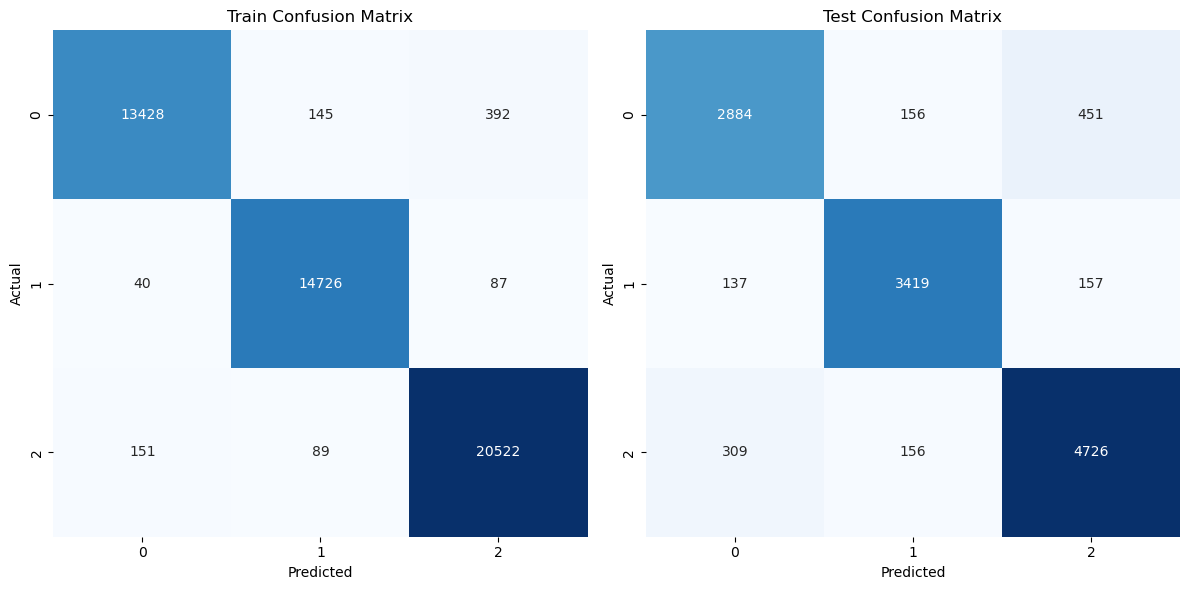


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     13965
           1       0.99      0.99      0.99     14853
           2       0.99      0.99      0.99     20762

    accuracy                           0.99     49580
   macro avg       0.99      0.99      0.99     49580
weighted avg       0.99      0.99      0.99     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      3491
           1       0.91      0.92      0.92      3713
           2       0.89      0.91      0.90      5191

    accuracy                           0.89     12395
   macro avg       0.89      0.89      0.89     12395
weighted avg       0.89      0.89      0.89     12395



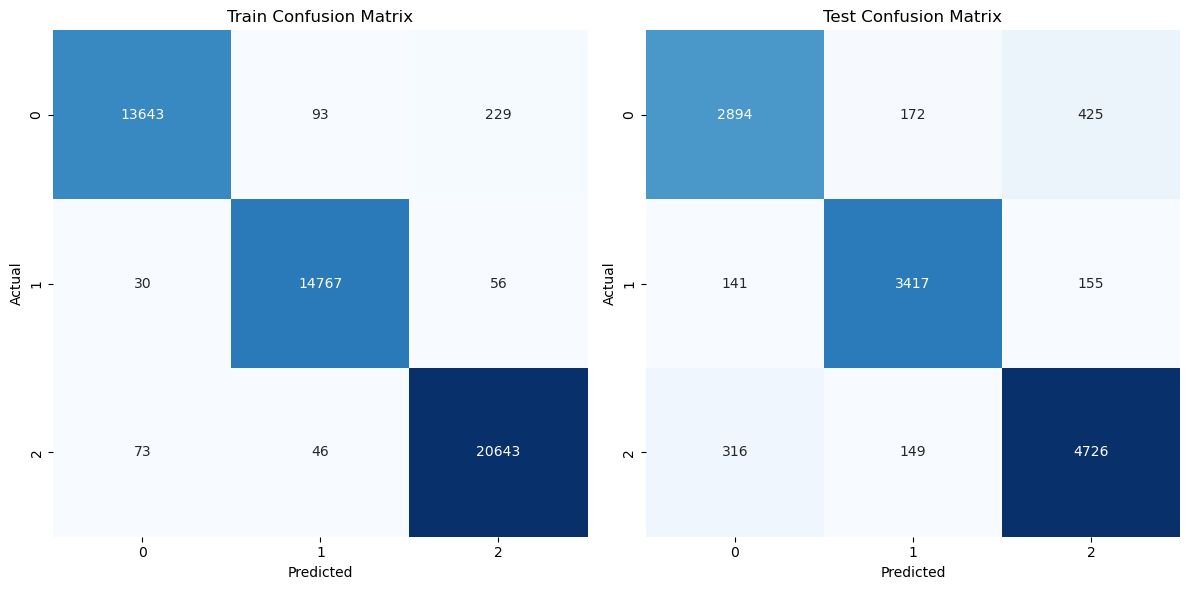


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     13965
           1       1.00      1.00      1.00     14853
           2       0.99      1.00      0.99     20762

    accuracy                           0.99     49580
   macro avg       0.99      0.99      0.99     49580
weighted avg       0.99      0.99      0.99     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      3491
           1       0.91      0.91      0.91      3713
           2       0.89      0.91      0.90      5191

    accuracy                           0.89     12395
   macro avg       0.89      0.88      0.88     12395
weighted avg       0.89      0.89      0.89     12395



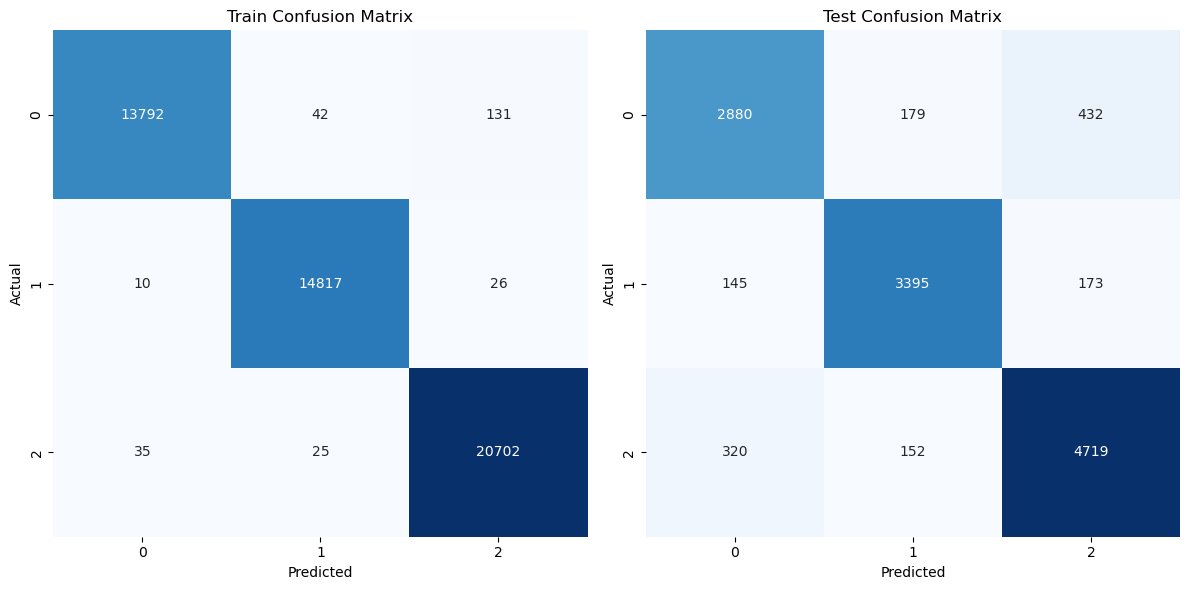


******************************************************************************************



,Estimator,Dataset,Accuracy,Precision,Recall,F1 Score,Embedding_dim,Embedding_model
0,XGBClassifier,Train,0.981767,0.982508,0.980479,0.981428,100,Skipgram
1,XGBClassifier,Test,0.889794,0.889486,0.885788,0.887423,100,Skipgram
2,XGBClassifier,Train,0.989371,0.989855,0.988474,0.989137,200,Skipgram
3,XGBClassifier,Test,0.890440,0.889479,0.886564,0.887864,200,Skipgram
4,XGBClassifier,Train,0.994574,0.994907,0.994099,0.994494,300,Skipgram
5,XGBClassifier,Test,0.886971,0.886172,0.882802,0.884310,300,Skipgram


In [10]:
skipgram_res_df = run_embedding_model_training(data_df=df,
                                               estimator=XGBClassifier(random_state=42),
                                               embedding_models=['skipgram_model_100.model', 'skipgram_model_200.model', 'skipgram_model_300.model'],
                                               embedding_type='skipgram')

skipgram_res_df

In [11]:
xgb_results_df = pd.concat([fasttext_res_df, word2vec_res_df, skipgram_res_df])
xgb_results_df

,Estimator,Dataset,Accuracy,Precision,Recall,F1 Score,Embedding_dim,Embedding_model
0,XGBClassifier,Train,0.979931,0.980354,0.978779,0.979534,100,Fasttext
1,XGBClassifier,Test,0.894796,0.893936,0.890977,0.892294,100,Fasttext
2,XGBClassifier,Train,0.990278,0.990505,0.989716,0.990099,200,Fasttext
3,XGBClassifier,Test,0.894474,0.894369,0.890283,0.892054,200,Fasttext
4,XGBClassifier,Train,0.993626,0.993682,0.993219,0.993445,300,Fasttext
5,XGBClassifier,Test,0.893505,0.893179,0.889075,0.890878,300,Fasttext
0,XGBClassifier,Train,0.980496,0.980656,0.979384,0.979992,100,Word2vec
1,XGBClassifier,Test,0.888987,0.887160,0.885862,0.886413,100,Word2vec
2,XGBClassifier,Train,0.988806,0.988980,0.988093,0.988526,200,Word2vec
3,XGBClassifier,Test,0.886809,0.886069,0.882281,0.883896,200,Word2vec


## Building baseline MLPClassifier

### Fasttext

- Embeddings are created.


/Users/saideepbunny/anaconda3/envs/huffpost_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report (Train):
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     13965
           1       0.97      0.95      0.96     14853
           2       0.95      0.96      0.95     20762

    accuracy                           0.95     49580
   macro avg       0.95      0.95      0.95     49580
weighted avg       0.95      0.95      0.95     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3491
           1       0.92      0.91      0.91      3713
           2       0.89      0.90      0.89      5191

    accuracy                           0.89     12395
   macro avg       0.88      0.88      0.88     12395
weighted avg       0.89      0.89      0.89     12395



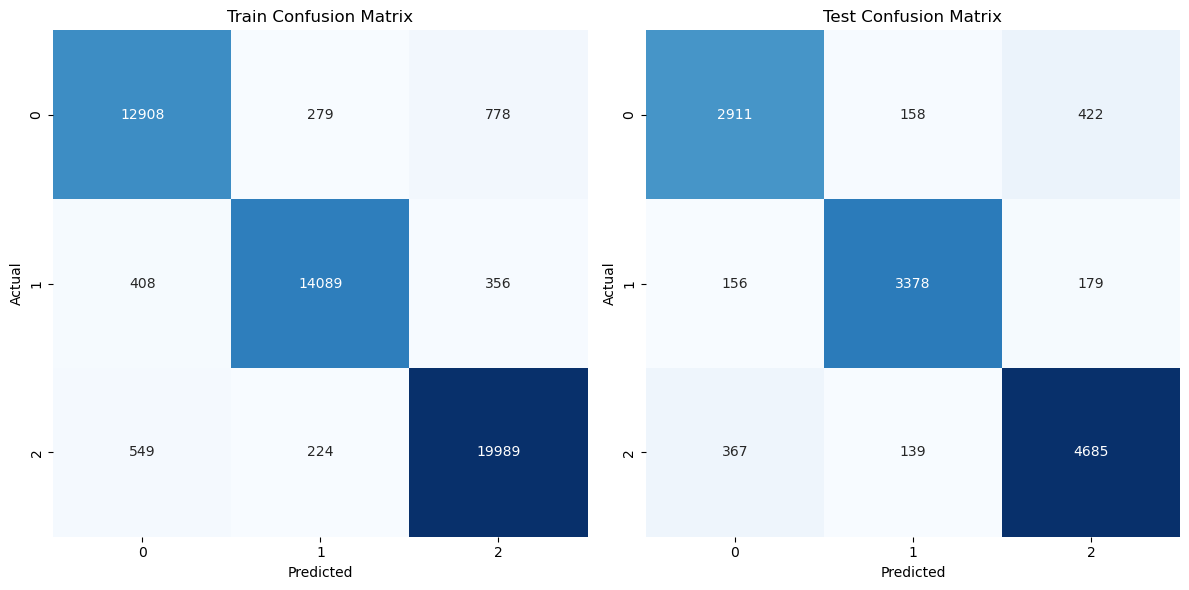


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.96      0.97      0.96     13965
           1       0.98      0.98      0.98     14853
           2       0.98      0.97      0.98     20762

    accuracy                           0.97     49580
   macro avg       0.97      0.97      0.97     49580
weighted avg       0.97      0.97      0.97     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      3491
           1       0.90      0.92      0.91      3713
           2       0.90      0.89      0.90      5191

    accuracy                           0.88     12395
   macro avg       0.88      0.88      0.88     12395
weighted avg       0.88      0.88      0.88     12395



/Users/saideepbunny/anaconda3/envs/huffpost_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


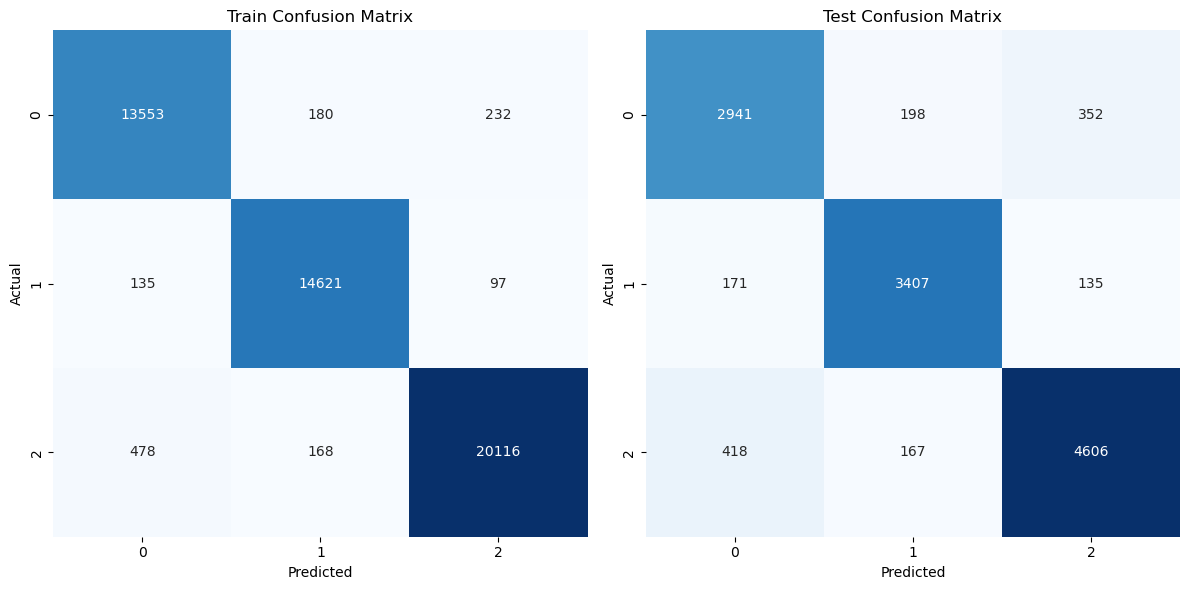


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     13965
           1       0.98      0.99      0.98     14853
           2       0.97      0.98      0.98     20762

    accuracy                           0.98     49580
   macro avg       0.98      0.98      0.98     49580
weighted avg       0.98      0.98      0.98     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      3491
           1       0.90      0.91      0.91      3713
           2       0.89      0.90      0.90      5191

    accuracy                           0.88     12395
   macro avg       0.88      0.88      0.88     12395
weighted avg       0.88      0.88      0.88     12395



/Users/saideepbunny/anaconda3/envs/huffpost_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


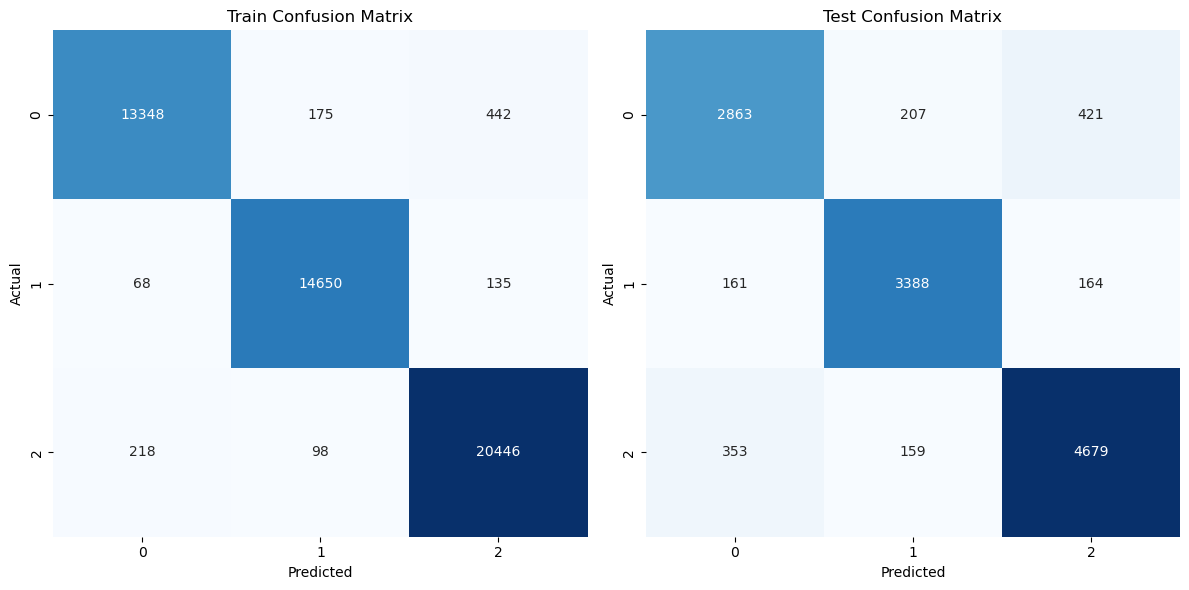


******************************************************************************************



,Estimator,Dataset,Accuracy,Precision,Recall,F1 Score,Embedding_dim,Embedding_model
0,MLPClassifier,Train,0.947681,0.947607,0.945214,0.946358,100,Fasttext
1,MLPClassifier,Test,0.885357,0.884396,0.882053,0.883173,100,Fasttext
2,MLPClassifier,Train,0.973981,0.972462,0.974588,0.973485,200,Fasttext
3,MLPClassifier,Test,0.883743,0.880252,0.882448,0.881296,200,Fasttext
4,MLPClassifier,Train,0.977088,0.977761,0.975644,0.976641,300,Fasttext
5,MLPClassifier,Test,0.881807,0.879722,0.877982,0.878752,300,Fasttext


In [12]:
fasttext_res_df = run_embedding_model_training(data_df=df,
                                               estimator=MLPClassifier(random_state=42),
                                               embedding_models=['fasttext_model_100.bin', 'fasttext_model_200.bin', 'fasttext_model_300.bin'],
                                               embedding_type='fasttext')

fasttext_res_df

### Word2Vec

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     13965
           1       0.98      0.98      0.98     14853
           2       0.99      0.98      0.98     20762

    accuracy                           0.98     49580
   macro avg       0.98      0.98      0.98     49580
weighted avg       0.98      0.98      0.98     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.79      0.82      0.80      3491
           1       0.89      0.87      0.88      3713
           2       0.87      0.86      0.87      5191

    accuracy                           0.85     12395
   macro avg       0.85      0.85      0.85     12395
weighted avg       0.85      0.85      0.85     12395



/Users/saideepbunny/anaconda3/envs/huffpost_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


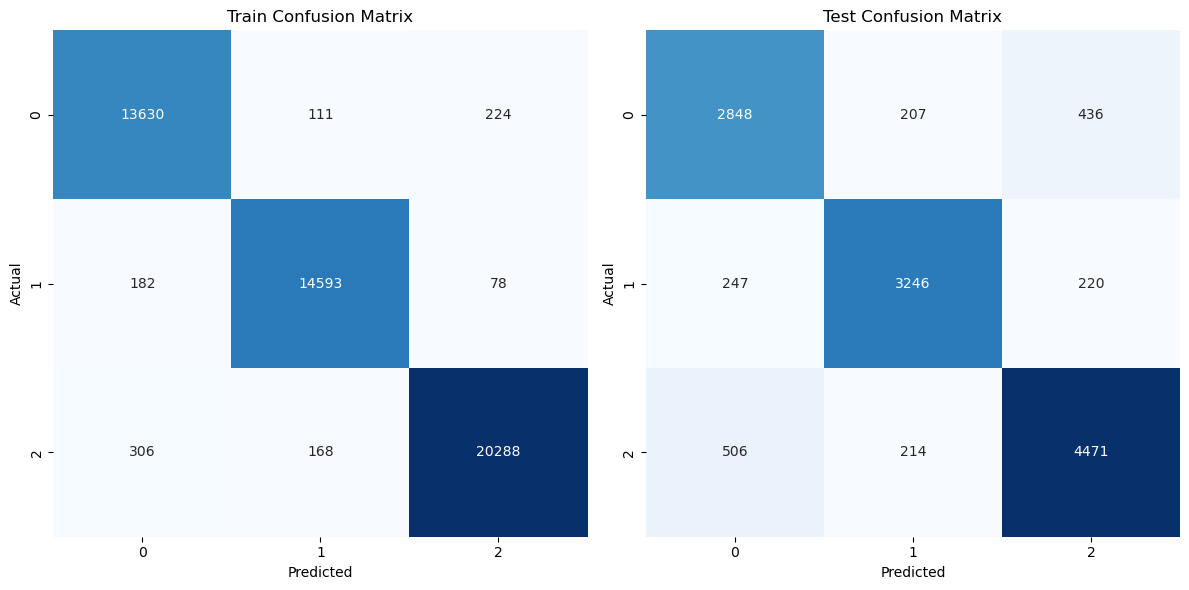


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13965
           1       1.00      1.00      1.00     14853
           2       1.00      1.00      1.00     20762

    accuracy                           1.00     49580
   macro avg       1.00      1.00      1.00     49580
weighted avg       1.00      1.00      1.00     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      3491
           1       0.88      0.89      0.89      3713
           2       0.88      0.86      0.87      5191

    accuracy                           0.86     12395
   macro avg       0.85      0.85      0.85     12395
weighted avg       0.86      0.86      0.86     12395



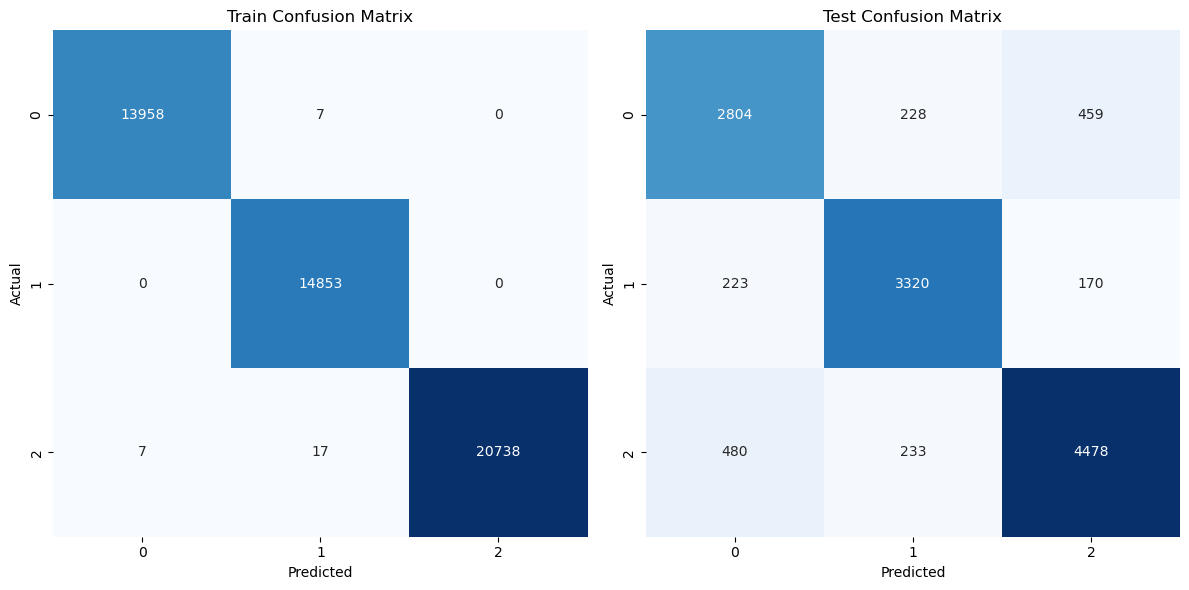


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13965
           1       1.00      1.00      1.00     14853
           2       1.00      1.00      1.00     20762

    accuracy                           1.00     49580
   macro avg       1.00      1.00      1.00     49580
weighted avg       1.00      1.00      1.00     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      3491
           1       0.90      0.89      0.90      3713
           2       0.87      0.88      0.88      5191

    accuracy                           0.86     12395
   macro avg       0.86      0.86      0.86     12395
weighted avg       0.86      0.86      0.86     12395



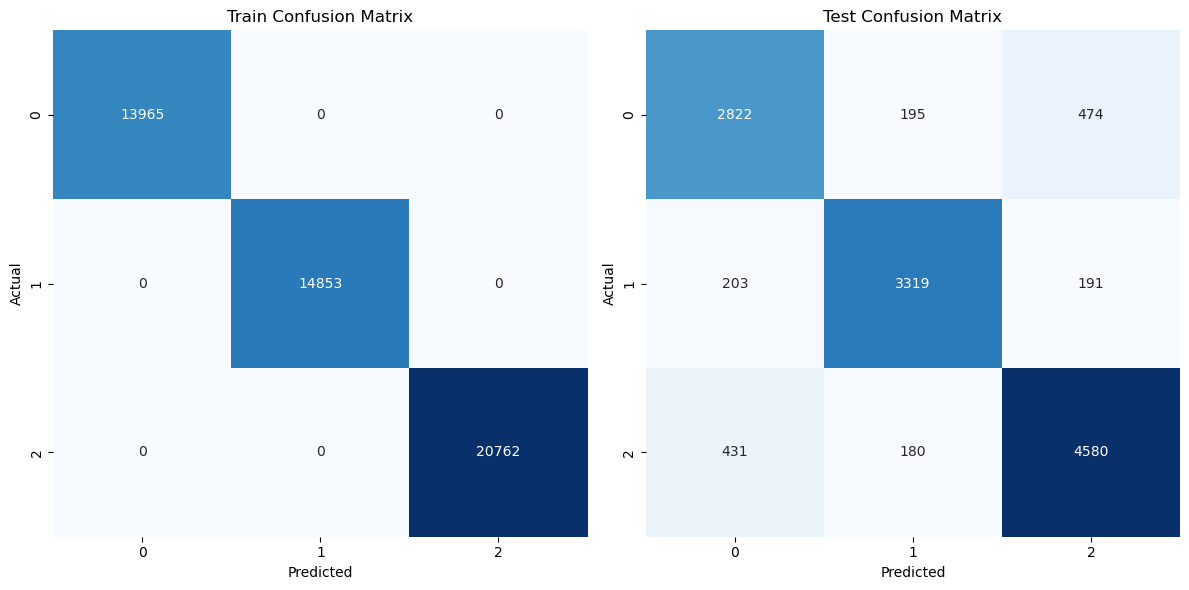


******************************************************************************************



,Estimator,Dataset,Accuracy,Precision,Recall,F1 Score,Embedding_dim,Embedding_model
0,MLPClassifier,Train,0.978439,0.977336,0.978559,0.977932,100,Word2vec
1,MLPClassifier,Test,0.852360,0.849378,0.850445,0.849825,100,Word2vec
2,MLPClassifier,Train,0.999375,0.999295,0.999448,0.999371,200,Word2vec
3,MLPClassifier,Test,0.855345,0.851485,0.853337,0.852366,200,Word2vec
4,MLPClassifier,Train,1.000000,1.000000,1.000000,1.000000,300,Word2vec
5,MLPClassifier,Test,0.864946,0.862749,0.861516,0.862116,300,Word2vec


In [13]:
word2vec_res_df = run_embedding_model_training(data_df=df,
                                               estimator=MLPClassifier(random_state=42),
                                               embedding_models=['word2vec_model_100.model', 'word2vec_model_200.model', 'word2vec_model_300.model'],
                                               embedding_type='word2vec')

word2vec_res_df

### Skipgram

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.97      0.94      0.96     13965
           1       0.98      0.97      0.97     14853
           2       0.96      0.99      0.97     20762

    accuracy                           0.97     49580
   macro avg       0.97      0.97      0.97     49580
weighted avg       0.97      0.97      0.97     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      3491
           1       0.91      0.91      0.91      3713
           2       0.87      0.89      0.88      5191

    accuracy                           0.87     12395
   macro avg       0.87      0.87      0.87     12395
weighted avg       0.87      0.87      0.87     12395



/Users/saideepbunny/anaconda3/envs/huffpost_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


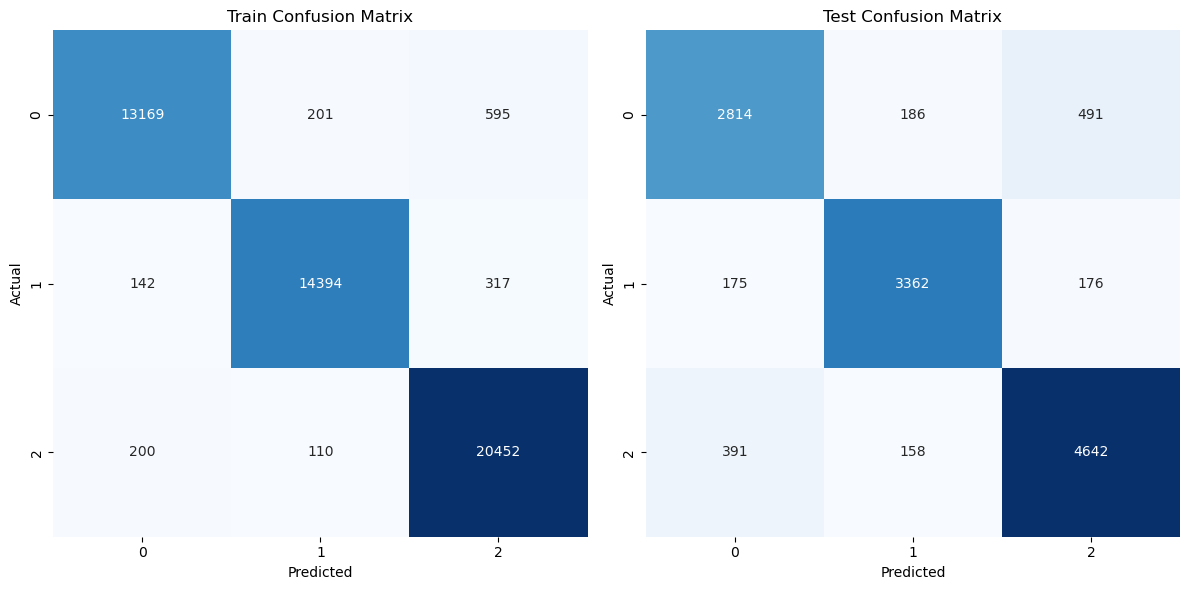


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13965
           1       1.00      1.00      1.00     14853
           2       1.00      1.00      1.00     20762

    accuracy                           1.00     49580
   macro avg       1.00      1.00      1.00     49580
weighted avg       1.00      1.00      1.00     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      3491
           1       0.90      0.90      0.90      3713
           2       0.89      0.87      0.88      5191

    accuracy                           0.87     12395
   macro avg       0.87      0.87      0.87     12395
weighted avg       0.87      0.87      0.87     12395



/Users/saideepbunny/anaconda3/envs/huffpost_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


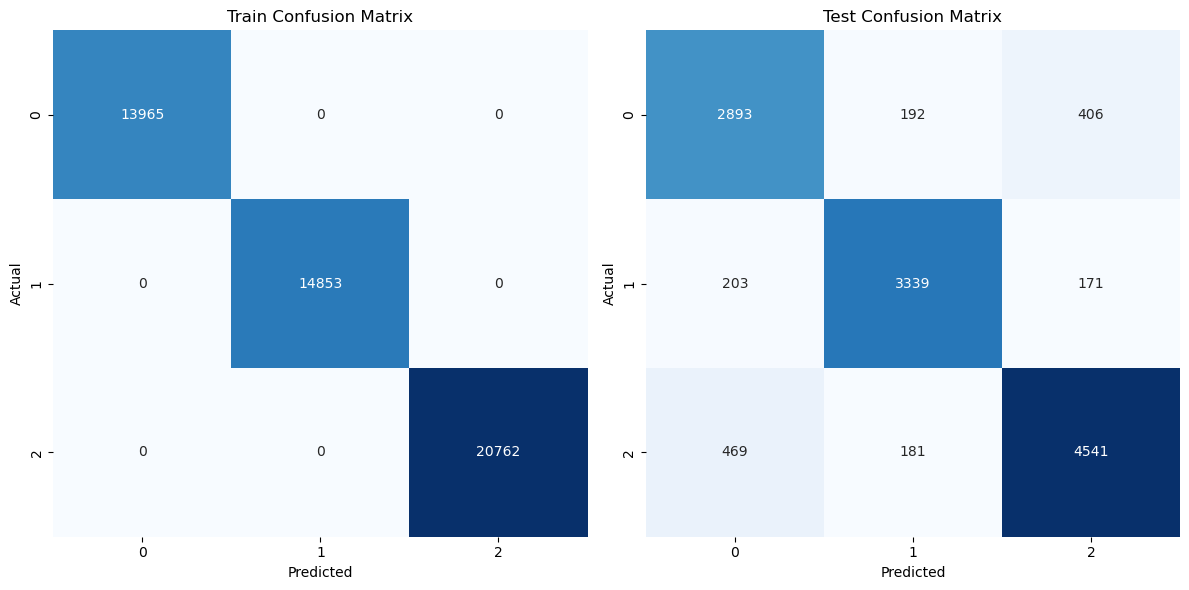


******************************************************************************************

- Embeddings are created.
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13965
           1       1.00      1.00      1.00     14853
           2       1.00      1.00      1.00     20762

    accuracy                           1.00     49580
   macro avg       1.00      1.00      1.00     49580
weighted avg       1.00      1.00      1.00     49580

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      3491
           1       0.91      0.89      0.90      3713
           2       0.86      0.91      0.89      5191

    accuracy                           0.88     12395
   macro avg       0.88      0.87      0.87     12395
weighted avg       0.88      0.88      0.88     12395



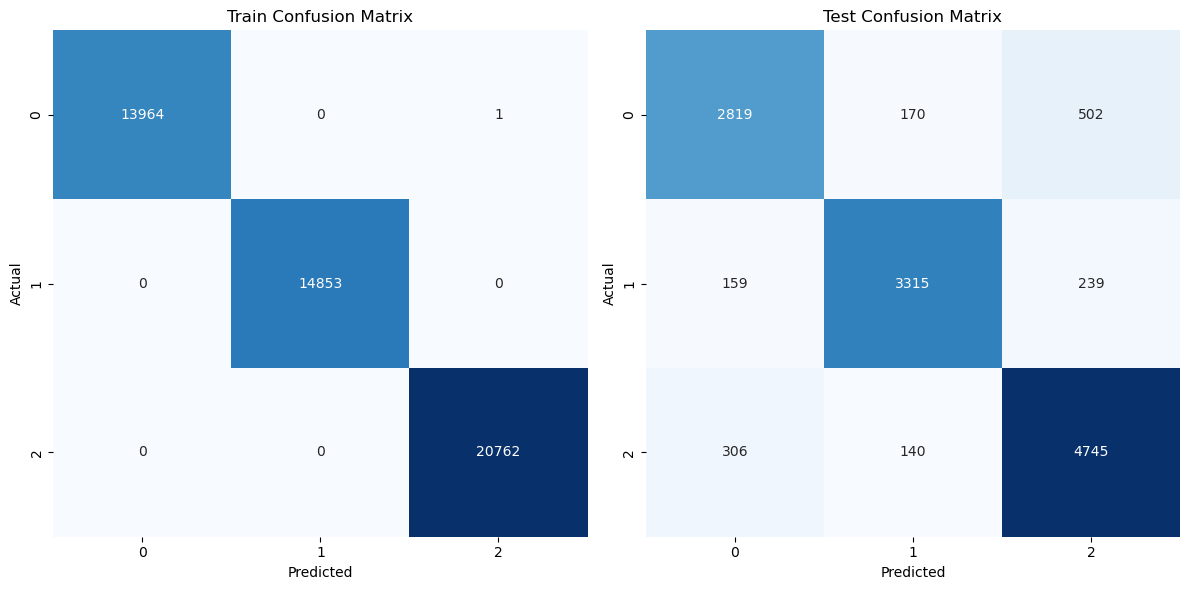


******************************************************************************************



,Estimator,Dataset,Accuracy,Precision,Recall,F1 Score,Embedding_dim,Embedding_model
0,MLPClassifier,Train,0.968435,0.970283,0.965722,0.967841,100,Skipgram
1,MLPClassifier,Test,0.872771,0.871362,0.868593,0.869869,100,Skipgram
2,MLPClassifier,Train,1.000000,1.000000,1.000000,1.000000,200,Skipgram
3,MLPClassifier,Test,0.869141,0.866092,0.867586,0.866794,200,Skipgram
4,MLPClassifier,Train,0.999980,0.999984,0.999976,0.999980,300,Skipgram
5,MLPClassifier,Test,0.877693,0.879272,0.871465,0.874840,300,Skipgram


In [14]:
skipgram_res_df = run_embedding_model_training(data_df=df,
                                               estimator=MLPClassifier(random_state=42),
                                               embedding_models=['skipgram_model_100.model', 'skipgram_model_200.model', 'skipgram_model_300.model'],
                                               embedding_type='skipgram')

skipgram_res_df

In [15]:
mlp_results_df = pd.concat([fasttext_res_df, word2vec_res_df, skipgram_res_df])
mlp_results_df

,Estimator,Dataset,Accuracy,Precision,Recall,F1 Score,Embedding_dim,Embedding_model
0,MLPClassifier,Train,0.947681,0.947607,0.945214,0.946358,100,Fasttext
1,MLPClassifier,Test,0.885357,0.884396,0.882053,0.883173,100,Fasttext
2,MLPClassifier,Train,0.973981,0.972462,0.974588,0.973485,200,Fasttext
3,MLPClassifier,Test,0.883743,0.880252,0.882448,0.881296,200,Fasttext
4,MLPClassifier,Train,0.977088,0.977761,0.975644,0.976641,300,Fasttext
5,MLPClassifier,Test,0.881807,0.879722,0.877982,0.878752,300,Fasttext
0,MLPClassifier,Train,0.978439,0.977336,0.978559,0.977932,100,Word2vec
1,MLPClassifier,Test,0.852360,0.849378,0.850445,0.849825,100,Word2vec
2,MLPClassifier,Train,0.999375,0.999295,0.999448,0.999371,200,Word2vec
3,MLPClassifier,Test,0.855345,0.851485,0.853337,0.852366,200,Word2vec


## Results

In [16]:
results_df = pd.concat([xgb_results_df, mlp_results_df])
results_df

,Estimator,Dataset,Accuracy,Precision,Recall,F1 Score,Embedding_dim,Embedding_model
0,XGBClassifier,Train,0.979931,0.980354,0.978779,0.979534,100,Fasttext
1,XGBClassifier,Test,0.894796,0.893936,0.890977,0.892294,100,Fasttext
2,XGBClassifier,Train,0.990278,0.990505,0.989716,0.990099,200,Fasttext
3,XGBClassifier,Test,0.894474,0.894369,0.890283,0.892054,200,Fasttext
4,XGBClassifier,Train,0.993626,0.993682,0.993219,0.993445,300,Fasttext
5,XGBClassifier,Test,0.893505,0.893179,0.889075,0.890878,300,Fasttext
0,XGBClassifier,Train,0.980496,0.980656,0.979384,0.979992,100,Word2vec
1,XGBClassifier,Test,0.888987,0.887160,0.885862,0.886413,100,Word2vec
2,XGBClassifier,Train,0.988806,0.988980,0.988093,0.988526,200,Word2vec
3,XGBClassifier,Test,0.886809,0.886069,0.882281,0.883896,200,Word2vec


In [17]:
results_df[results_df['Dataset'] == 'Test'].sort_values(['F1 Score'], ascending=False)

,Estimator,Dataset,Accuracy,Precision,Recall,F1 Score,Embedding_dim,Embedding_model
1,XGBClassifier,Test,0.894796,0.893936,0.890977,0.892294,100,Fasttext
3,XGBClassifier,Test,0.894474,0.894369,0.890283,0.892054,200,Fasttext
5,XGBClassifier,Test,0.893505,0.893179,0.889075,0.890878,300,Fasttext
3,XGBClassifier,Test,0.890440,0.889479,0.886564,0.887864,200,Skipgram
1,XGBClassifier,Test,0.889794,0.889486,0.885788,0.887423,100,Skipgram
1,XGBClassifier,Test,0.888987,0.887160,0.885862,0.886413,100,Word2vec
5,XGBClassifier,Test,0.886971,0.886172,0.882802,0.884310,300,Skipgram
3,XGBClassifier,Test,0.886809,0.886069,0.882281,0.883896,200,Word2vec
1,MLPClassifier,Test,0.885357,0.884396,0.882053,0.883173,100,Fasttext
3,MLPClassifier,Test,0.883743,0.880252,0.882448,0.881296,200,Fasttext


XGBClassifier and Fasttext seem to perform the best. Therefore promoting XGBoost as the model of choice and hyper parameter optimization will be done for each of the fasttext models (of different embedding sizes)